In [294]:
import numpy as np
import pandas as pd
import re, nltk, spacy, gensim, string
from nltk.corpus import stopwords
from collections import Counter
from gensim.summarization import summarize
from gensim.summarization import keywords
import time as time

# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.model_selection import GridSearchCV
from pprint import pprint
from tqdm import tqdm
import multiprocessing as mp

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

%matplotlib inline

In [2]:
# A custom function to clean the text before sending it into the vectorizer
def cleanText(text):
    
    # replace ;
    text = text.replace(" ; ", "\n")
    
    table = str.maketrans('', '', string.punctuation)
    # get rid of punctuation
    text = text.translate(table)
    
    # get rid of newlines
    text = text.strip().replace("\n", ". ").replace("\r", ".")
    
    # replace twitter @mentions
    mentionFinder = re.compile(r"@[a-z0-9_]{1,15}", re.IGNORECASE)
    text = mentionFinder.sub("@MENTION", text)
    
    # replace HTML symbols
    text = text.replace("&amp;", "and").replace("&gt;", ">").replace("&lt;", "<")
    
    # lowercase
    text = text.lower()

    return text

def calc_score(ref, comp, debug=False):
    '''gives the number of items in ref that is also found in comp'''
    ## check if it is a list of strings
    if not isinstance(ref, list):
        ref = str(ref).split()
    if not isinstance(comp, list):
        comp = str(comp).split()
        
    s_ref = set(ref)
    s_comp = set(comp)
    s_inter = s_comp.intersection(s_ref)
    if debug:
        print(s_ref, len(s_ref))
        print(s_comp)
        print(s_inter, len(s_inter))
    return len(s_inter)/len(s_ref)

In [212]:
# A custom stoplist
STOPLIST = set(stopwords.words('english') + ["n't", "'s", "'m", "ca"] + list(ENGLISH_STOP_WORDS))
# List of symbols we don't care about
SYMBOLS = " ".join(string.punctuation).split(" ") + ["-----", "---", "...", "“", "”", "'ve", "\n", "", " ", "\n\n", "npr"]

def lemming(data, keeptype=[], doalpha=False, dostop=True):
    tokens = []
    for tok in data:
        
        # stoplist the tokens
        if dostop:
            if tok.text not in STOPLIST:
                pass
            else:
                continue
            ##check if the token is stopword
            if not tok.is_stop:
                pass
            else:
                continue
        else:
            pass
        
        # stoplist symbols
        if tok.text not in SYMBOLS:
            pass
        else: 
            continue
        
        ##check if the token is alpha
        if doalpha:
            if tok.is_alpha:
                pass
            else:
                continue
        else:
            pass
        
        ##check if the token is noun
        if len(keeptype) > 1:
            if tok.pos_ in keeptype:
                pass
            else:
                continue
        else:
            pass
    
        # lemmatize
        if tok.lemma_ != "-PRON-" :
            tokens.append(tok.lemma_.lower().strip())
        else:
            tokens.append(tok.lower_)
    
    # remove large strings of whitespace
    return tokens

In [213]:
# Initialize spacy 'en' model
nlp = spacy.load('en')

# Initialize vectorizer
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=1,                        # minimum reqd occurences of a word 
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

In [308]:
sumtoken = []
token = []

token_filter = []
token_gensim_sentence = []
token_gensim_word = []

 ##304 NPR, 96 conv, 419 story
path = 'Data/NPR/'
N = 1
if "_story" in path: ## 124 seconds
    N = 419
elif "_conv" in path: ## 81 seconds
    N = 96
elif "NPR" in path: ## 31 seconds
    N = 304
    
fulltextdic = {}

def TextToTokens(i=1):
    '''input is file name
    tranlsate the file, file summary'''
    result = {}
    with open(path + str(i) + '_trans.txt', 'r') as myfile:
        temp_text = cleanText(myfile.read()) ##this is a string
        #print(type(temp_text))
    with open(path + str(i) + '.txt', 'r') as myfile:
        ## remove the last element which is a date; for summary only
        temp_sumtext = " ".join(cleanText(myfile.read()).split(" ")[:-1]) ## this is also a string
        ##print(temp_sumtext, type(temp_text))
    
    ## calculate the maximum score
    nlp_temp_text = nlp("".join(temp_text)) ## this is spacy token
    nlp_temp_sumtext = nlp("".join(temp_sumtext)) ## this is spacy token
    
    ## do lemming
    result["text"] = lemming(nlp_temp_text)
    result["sumtext"] = lemming(nlp_temp_sumtext)
    result["textfilter"] = lemming(nlp_temp_text, doalpha=True, keeptype=["NOUN", "PROPN", "NUM", "ADJ", "ADV"])

#     token.append(lemming(nlp_temp_text))
#     token_alltype.append(lemming(nlp_temp_text, doalpha=False, dostop=True, keeptype=[]))
#     sumtoken.append(lemming(, doalpha=False, dostop=True, keeptype=[]))
    
    ## try gensim sentence
    ratio = len(temp_sumtext)/len(temp_text)
    sum_gensim = summarize("".join(temp_text), ratio=ratio, split=True) #this is a list
    result["gensim_sentence"] = lemming(nlp(" ".join(sum_gensim)))
    
    ## gensim keywords; use lemmed full text
    #print(" ".join(result["text"]))
    result["gensim_word"] =  keywords(" ".join(result["text"]), words=len(result["sumtext"]), split=True, lemmatize=True, deacc=True)
    return {i:result}

start_time = time.time()
inputtasks = range(N)
npool = min(len(inputtasks), mp.cpu_count()-2)
print(" Running %s jobs on %s cores" % (len(inputtasks), mp.cpu_count()-2))
pool  = mp.Pool(npool)

for r in pool.map(TextToTokens, inputtasks):
    fulltextdic.update(r)

print("Done!!")
print("--- %s seconds ---" % (time.time() - start_time))
# for i in tqdm(range(2)):
#     fulltextdic.update(TextToTokens(i))

 Running 304 jobs on 6 cores


Done!!
--- 124.64852523803711 seconds ---


In [333]:
best_rate     = []
base_rate     = []
filter_rate   = []
gensimsentence_rate = []
gensimkeyword_rate  = []
comb_rate  = []

for i in tqdm(range(N)):
#for i in tqdm(range(1)):
    ## calculate the maximum score
    token = fulltextdic[i]["text"]
    token_sum = fulltextdic[i]["sumtext"]
    token_filter = fulltextdic[i]["textfilter"]
    token_gensimsentence = fulltextdic[i]["gensim_sentence"]
    token_gensimkeyword = fulltextdic[i]["gensim_word"]
    length = len(token_sum)
    
    ## best score: Nwords in sum also in token
    best_score = calc_score(ref=token_sum, comp=token, debug=False)
    
    ## baseline score: high frequency words
    words_base = [w[0] for w in Counter(token).most_common(length)]
    words_base.sort(key=lambda x: token.index(x))
    base_score =  calc_score(ref=token_sum, comp=words_base, debug=False)

    words_filter = [w[0] for w in Counter(token_filter).most_common(length)]
    words_filter.sort(key=lambda x: token_filter.index(x))
    filter_score = calc_score(ref=token_sum, comp=words_filter, debug=False)
    
    gensimsentence_score = calc_score(ref=token_sum, comp=token_gensimsentence, debug=False)

    gensimkeyword_score = calc_score(ref=token_sum, comp=token_gensimkeyword, debug=False)
    
    comb_words = [w[0] for w in Counter(words_filter + token_gensimkeyword).most_common(length)]
    comb_score = calc_score(ref=token_sum, comp=comb_words, debug=False)
    
    best_rate.append(best_score)
    base_rate.append(base_score
    filter_rate.append(filter_score
    gensimsentence_rate.append(gensimsentence_score
    gensimkeyword_rate.append(gensimkeyword_score
    comb_rate.append(comb_score)
    
    if comb_score/best_score > 0.6:
        print(" ".join(token_sum))
        print("best score", best_score, "\n")
        print(" ".join(words_base))
        print("baseline score", base_score, "\n")
        print(" ".join(token_gensimsentence))
        print("gensimsentence score", gensimsentence_score, "\n")
        print(" ".join(words_filter))
        print("my score", my_score, "\n")
        print(" ".join(token_gensimkeyword))
        print("gensimskeyword score", gensimkeyword_score, "\n")
        print(" ".join(comb_words))
        print("comb score", comb_score, "\n")

SyntaxError: invalid syntax (<ipython-input-333-f9718bc02b3a>, line 39)

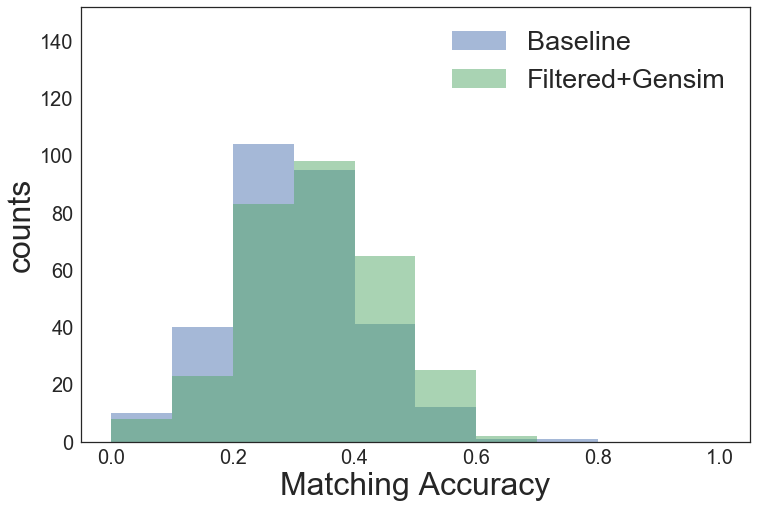

In [336]:
plt.clf()
plt.figure(figsize=(12, 8))
mybins=np.arange(0, 1.05, 0.1)
plt.hist(base_rate, alpha=0.5, bins=mybins, label="Baseline") #; mean %.3f %s %.3f " % (np.mean(np.array(base_rate)), r'$\pm$', np.std(np.array(base_rate)/np.sqrt(N))))
#plt.hist(filter_rate, alpha=0.5, bins=mybins, label="Filtered") #; mean %.3f %s %.3f" % (np.mean(np.array(my_rate)), r'$\pm$', np.std(np.array(my_rate))/np.sqrt(N)))
#plt.hist(gensimsentence_rate, alpha=0.5, bins=mybins, label="Gensim sentence") #; mean %.3f %s %.3f " % (np.mean(np.array(gensim_rate)), r'$\pm$', np.std(np.array(gensim_rate)/np.sqrt(N))))
#plt.hist(gensimkeyword_rate, alpha=0.5, bins=mybins, label="Gensim keywords") #; mean %.3f %s %.3f " % (np.mean(np.array(gensimkeyword_rate)), r'$\pm$', np.std(np.array(gensimkeyword_rate)/np.sqrt(N))))
plt.hist(comb_rate, alpha=0.5, bins=mybins, label="Filtered+Gensim") #; mean %.3f %s %.3f " % (np.mean(np.array(gensimkeyword_rate)), r'$\pm$', np.std(np.array(gensimkeyword_rate)/np.sqrt(N))))
plt.ylim(0, N/2)
#plt.xlabel(r"$N_{matched}^{InDescription}$ / $N_{total}^{InDescription}$", fontsize=32)
plt.xlabel("Matching Accuracy", fontsize=32)
plt.ylabel("counts", fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title("", fontsize=40)
plt.legend(fontsize=27)
plt.savefig("Plot/" + path.split("/")[1] + "_compare.pdf")
plt.show()

In [186]:
print(" ".join(common_words_alltype), "\n")
print(" ".join(topic), "\n")

come day secretary congress lot look right want year need work talk present 

day secretary afghanistan congress lot right big people not year wall troop house 



In [190]:
print(" ".join(test_sumtoken), len(test_sumtoken), "\n")
print("".join(test_gensimkeyword_token), len(test_gensimkeyword_token.split(" ")),"\n")
print(" ".join(test_gensim_token), len(test_gensim_token), "\n")
print(" ".join(sum_gensim), "\n")

united state strategy afghanistan congress able deliver president trump agenda continue fund government 13 

come new political politic polite want right day news secretary talk year congress lot need work 16 

super krueger get catch close plus job site single clicking screen read pirate right candidate fact try trigger free exit recruiter dot com slash outburst support come morgan stanley join forget family start financial adviser understand bring family 38 

with super krueger got caught you can close to one hundred plus job sites all of a single clicking screen and read a pirate right candidate in fact tries to trigger for free exit recruiter dot com slash outbursts can support also comes from morgan stanley well joining forgotten family starts with a financial adviser who understands how to bring families together. 



In [191]:
print(" ".join(test_text), ratio, "\n")
summarize("".join(test_text), ratio=0.1, split=True)

our good morning steve inskeep rachel one will come back because they visited is monday april twenty fourth and this is a first your first word of the days news. that secretary jim medicines in afghanistan. he was recently dropped a giant on there but to whats the strategy and resin jobs administration has ambitious plans were reducing the role of government in your life during the first hundred days were doing so one truly historic basis the president is asking congress for a lot that while lawmakers actually prepared to give him we also look ahead to the decisive around. of frances presidential election after sundays vote off our right nationalist fates are political newcomers so whats the vote tell us about one of europes leading edge serbs they were the staff were given you should be get to the. are solicitors jackass comes from sid do the. with super krueger got caught you can close to one hundred plus job sites all of a single clicking screen and read a pirate right candidate in 

['our good morning steve inskeep rachel one will come back because they visited is monday april twenty fourth and this is a first your first word of the days news.',
 'he was recently dropped a giant on there but to whats the strategy and resin jobs administration has ambitious plans were reducing the role of government in your life during the first hundred days were doing so one truly historic basis the president is asking congress for a lot that while lawmakers actually prepared to give him we also look ahead to the decisive around.',
 'with super krueger got caught you can close to one hundred plus job sites all of a single clicking screen and read a pirate right candidate in fact tries to trigger for free exit recruiter dot com slash outbursts can support also comes from morgan stanley well joining forgotten family starts with a financial adviser who understands how to bring families together.',
 'but didnt us defense secretarys visit comes on the head of bigger question the questi

In [175]:
print(" ".join(test_sumtext))

berryl anderson was a class clown and troublemaker when she was growing up but her mom taught her that it wasnt enough to be smart she also had to be a good person and be respectful of other people now shes a judge in dekalb county gaap


## Merge all txt files into one

In [ ]:
test_text = []
test_sumtext   = []
for i in tqdm(range(N)):
    with open(path + str(i) + '_trans.txt', 'r') as myfile:
        test_text.append(cleanText(myfile.read()))
    with open(path + str(i) + '.txt', 'r') as myfile:
        cleaned_sum = cleanText(myfile.read())
        ## pop the last date out
        test_sumtext.append(" ".join(cleaned_sum.split(" ")[:-1]))

In [ ]:
out_text = open('all_trans.txt', 'w')
for item in test_text:
    out_text.write("%s\n" % item)
out_text.close()

out_sumtext = open('all_sum.txt', 'w')
for item in test_sumtext:
    out_sumtext.write("%s\n" % item)
out_sumtext.close()

## Gensim fasttext

In [ ]:
from gensim.models import FastText
sentences_1 = [["cat", "say", "meow"], ["dog", "say", "woof"]]
sentences_2 = [["dude", "say", "wazzup!"]]

model = FastText(min_count=1)
model.build_vocab(sentences_1)
model.train(sentences_1, total_examples=model.corpus_count, epochs=model.iter)
model.build_vocab(sentences_2, update=True)
model.train(sentences_2, total_examples=model.corpus_count, epochs=model.iter)

In [ ]:
say_vector = model['say']

In [ ]:
say_vector

In [ ]:
audio_length= "%.1g sec" % 3.111
audio_length